In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols, simplify
from sympy import init_printing, latex
from sympy import S
from scipy.integrate import odeint
import numpy as np
init_printing(latex)

In [2]:
import rebound
import numpy as np

logmass = -5.1
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000
m_res=9

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m_res+1)/m_res)
sim.move_to_com()

In [3]:
Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Lambda1, lambda1), (Lambda2, lambda2), (Gamma1, gamma1), (Gamma2, gamma2)]
m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, mu1, mu2, alpha, m, f27, f31]

H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H = H0 - m1/M1*mu2/Lambda2**2*(f27*sqrt(Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1) + f31*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)) 

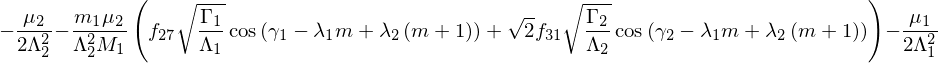

In [4]:
H

In [5]:
from celmech.hamiltonian import make_Hamiltonian
Hp = make_Hamiltonian(H, actionanglepairs, params)

In [6]:
from celmech.transformations import sim_to_poincare
ic, Nparams = sim_to_poincare(sim, 1, 2, average_synodic_terms=True)

In [7]:
from celmech.disturbing_function import laplace_coefficient 
Nf27 = 1/2*(-2*(m_res+1)*laplace_coefficient(0.5, m_res+1, 0, Nparams['alpha']) - Nparams['alpha']*laplace_coefficient(0.5, m_res+1, 1, Nparams['alpha']))
Nf31 = 1/2*((2*m_res+1)*laplace_coefficient(0.5, m_res, 0, Nparams['alpha']) + Nparams['alpha']*laplace_coefficient(0.5, m_res, 1, Nparams['alpha']))        

In [8]:
hp = Hp(**Nparams, m=m_res, f27=Nf27, f31=Nf31)

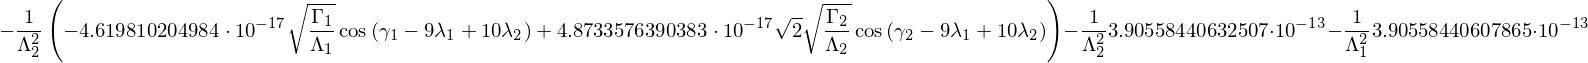

In [9]:
hp.H

In [10]:
%%time
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
symsol = hp.integrate(ic, times)

Nsol = {'Lambda1':np.zeros(Nout), 'Lambda2':np.zeros(Nout), 'lambda1':np.zeros(Nout), 'lambda2':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    var, Nparams = sim_to_poincare(sim, 1, 2)
    for key in Nsol.keys():
        Nsol[key][i] = var[key]

CPU times: user 1.26 s, sys: 6.38 ms, total: 1.27 s
Wall time: 1.27 s


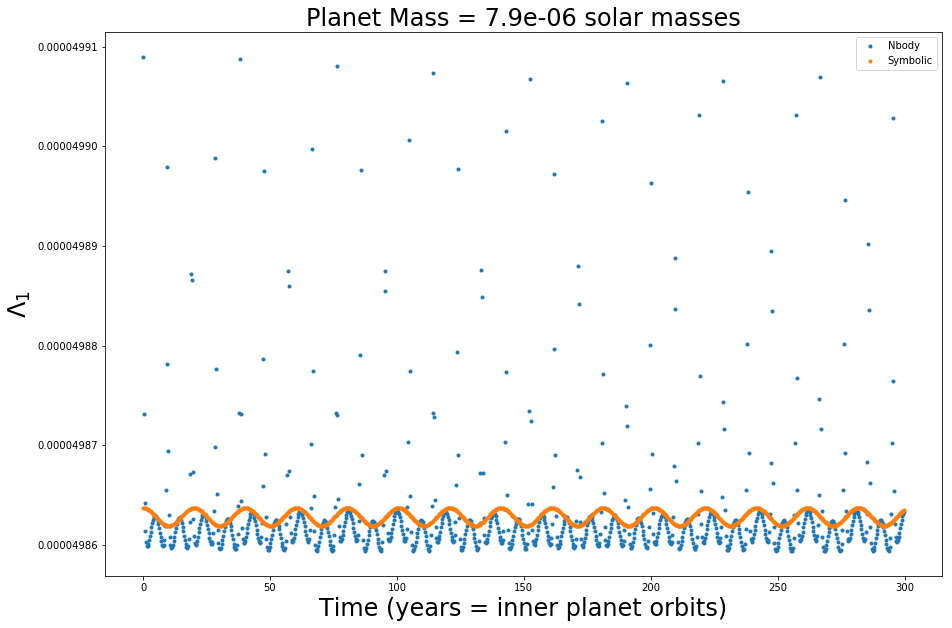

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_1$", fontsize=24)

ax.plot(times, Nsol['Lambda1'], '.', label='Nbody')
ax.plot(times, symsol['Lambda1'], '.', label='Symbolic')

ax.legend()

In [12]:
theta, theta1, Theta, Theta1 = S('theta, theta1, Theta, Theta1')
#Lambda1 = Theta1 - m*Theta
#Lambda2 = (m+1)*Theta
#theta = (m+1)*lambda2 - m*lambda1
#theta1 = lambda1

In [13]:
Htheta = H.subs(Lambda1, Theta1 - m*Theta)
Htheta = Htheta.subs(Lambda2, (m+1)*Theta)
Htheta = Htheta.subs(lambda1, theta1)
Htheta = Htheta.subs(lambda2, (theta + m*theta1)/(m+1))

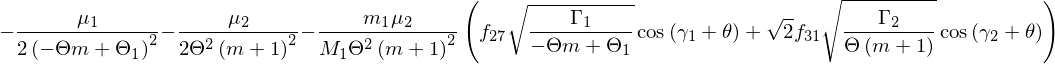

In [14]:
Htheta

In [15]:
# Actionnew = Action/Theta1, Action = Actionnew*Theta1

In [16]:
Htheta = Htheta.subs(Theta, Theta*Theta1)
Htheta = Htheta.subs(Gamma1, Gamma1*Theta1)
Htheta = Htheta.subs(Gamma2, Gamma2*Theta1)

In [17]:
Htheta /= mu2/Theta1**2
Htheta = simplify(Htheta)

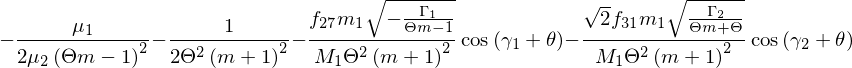

In [18]:
Htheta

In [19]:
#Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Theta, theta), (Gamma1, gamma1), (Gamma2, gamma2)]
#m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, mu1, mu2, alpha, m, f27, f31]

In [20]:
Htheta = make_Hamiltonian(Htheta, actionanglepairs, params)

In [21]:
def thetas_from_sim(sim, inner, outer, m, average_synodic_terms=False, scales=None):
    var, params = sim_to_poincare(sim, inner, outer, average_synodic_terms=average_synodic_terms)
    params['m'] = m
    Theta = var['Lambda2']/(m+1)
    Theta1 = m/(m+1)*var['Lambda2'] + var['Lambda1']
    theta = (m+1)*var['lambda2'] - m*var['lambda1']
    theta1 = var['lambda1']
    
    if scales is None:
        scales = {'actionscale':Theta1, 'timescale':Theta1**3/params['mu2']}
    
    actionscale = scales['actionscale']
    var =  {'Theta':Theta/actionscale, 'Theta1':Theta1/actionscale, 'theta':theta, 'theta1':theta1, 'Gamma1':var['Gamma1']/actionscale, 'Gamma2':var['Gamma2']/actionscale, 'gamma1':var['gamma1'], 'gamma2':var['gamma2']}
    return var, params, scales

In [32]:
import rebound
import numpy as np

logmass = -5.1
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000
m_res=6

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m_res+1)/m_res)
sim.move_to_com()

In [33]:
ic, Nparams, scales = thetas_from_sim(sim, 1, 2, m_res, average_synodic_terms=True)
#m=params['m']
#alpha = params['alpha']
#f27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))
#f31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))        

In [34]:
htheta = Htheta(**Nparams, f27=Nf27, f31=Nf31)

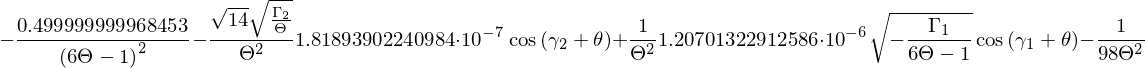

In [35]:
htheta.H

In [36]:
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
timescale = scales['timescale']
normtimes = [t/timescale for t in times]
symsol = htheta.integrate(ic, normtimes)

Nsol = {'Theta':np.zeros(Nout), 'Theta1':np.zeros(Nout), 'theta':np.zeros(Nout), 'theta1':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    var, Nparams, scales = thetas_from_sim(sim, 1, 2, m_res, scales=scales)
    for key in Nsol.keys():
        Nsol[key][i] = var[key]

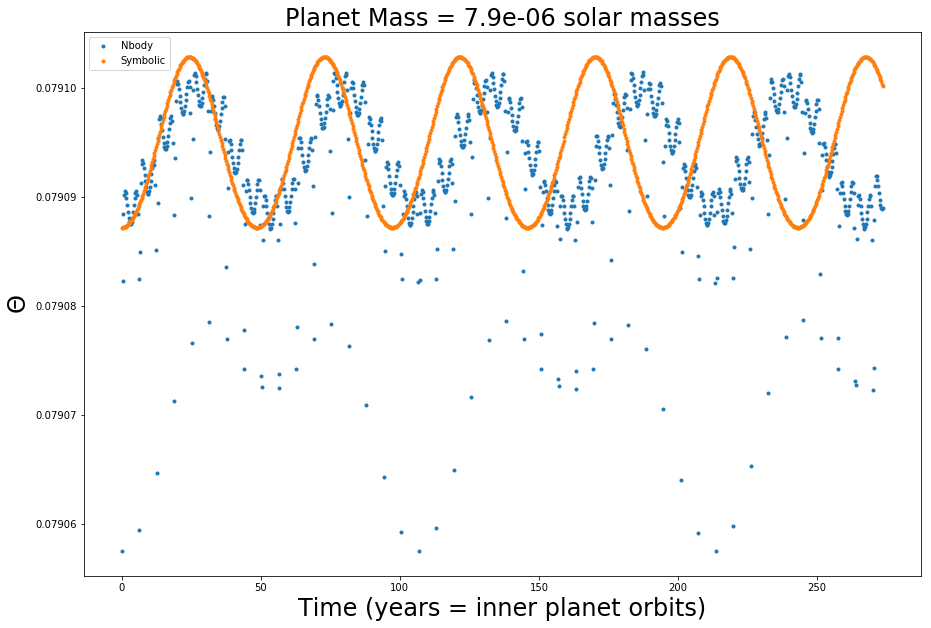

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Theta$", fontsize=24)

ax.plot(normtimes, Nsol['Theta'], '.', label='Nbody')
ax.plot(normtimes, symsol['Theta'], '.', label='Symbolic')

ax.legend()

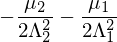

In [25]:
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H0

In [33]:
dL_1, dL_2 = S('dL_1, dL_2')
H0 = -mu1/(2*((2*m1/m2*sqrt(alpha) + dL_1)**2)) - mu2/(2*(2 + dL_2)**2)

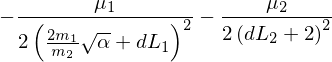

In [34]:
H0

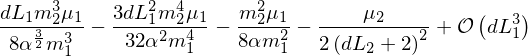

In [54]:
from sympy import series
series(H0, dL_1, 0, 3)

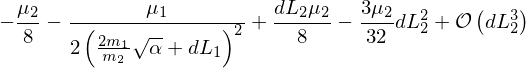

In [56]:
series(H0, dL_2, 0, 3)